In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data()
fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'))
fitness_df = fitness_df[list(fitness_df.columns[:4]) + list(fitness_df.columns[-2:]) + list(fitness_df.columns[4:-2])]
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples.pddl']


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [5]:
def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = ('interactive-beta.pddl', 'ast-real-regrowth-samples.pddl'),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [6]:
filtered_fitness_df.head()

,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1.0,1.0,1.0,1.00,...,0,0,1,0,0,1,0,0,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1.0,1.0,1.0,1.00,...,0,0,1,0,0,0,0,0,1,0
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1.0,1.0,1.0,0.00,...,1,0,0,0,0,0,1,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1.0,1.0,1.0,0.00,...,1,0,0,0,0,1,0,0,0,0
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1.0,1.0,1.0,0.25,...,1,0,0,0,0,0,0,1,0,0


In [7]:
display(Markdown(filtered_fitness_df.iloc[:, [4] + list(range(18, 20)) + [21, 22, 23]].groupby('real').mean(numeric_only=True).to_markdown()))

|   real |   pref_forall_correct_arity |   pref_forall_correct_types |   no_two_number_operations |   section_without_pref_count_terminal |   section_without_pref_count_scoring |
|-------:|----------------------------:|----------------------------:|---------------------------:|--------------------------------------:|-------------------------------------:|
|      0 |                    0.976299 |                    0.973262 |                   0.985209 |                              0.540816 |                                    0 |
|      1 |                    1        |                    1        |                   1        |                              0.540816 |                                    0 |

In [8]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == 'ast-real-regrowth-samples.pddl'].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 4.45% of the games, the regrown game was identical to the original game.


In [9]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

correct_predicate_function_arity
section_without_pref_count_terminal
section_without_pref_count_scoring
arg_types_adjacent_any_object_blocks
arg_types_adjacent_any_object_building
arg_types_adjacent_any_object_ramps
arg_types_adjacent_any_object_room_features
arg_types_adjacent_any_object_small_objects
arg_types_adjacent_balls_any_object
arg_types_adjacent_blocks_ramps
arg_types_adjacent_colors_any_object
arg_types_adjacent_colors_blocks
arg_types_adjacent_colors_large_objects
arg_types_adjacent_colors_ramps
arg_types_adjacent_colors_receptacles
arg_types_adjacent_colors_room_features
arg_types_adjacent_colors_small_objects
arg_types_adjacent_furniture_colors
arg_types_adjacent_furniture_small_objects
arg_types_adjacent_building_agent
arg_types_adjacent_building_any_object
arg_types_adjacent_building_balls
arg_types_adjacent_building_colors
arg_types_adjacent_building_large_objects
arg_types_adjacent_building_ramps
arg_types_adjacent_building_small_objects
arg_types_adjacent_large_obje

In [10]:
sum(never_change)

156

In [11]:
original_df = filtered_fitness_df[filtered_fitness_df.src_file == 'interactive-beta.pddl'].reset_index(drop=True)
arr = np.array(original_df.all_variables_used) 
ind = np.where(arr != 1)[0]
print(ind)
original_df.iloc[ind, :]

[]


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,node_count_terminal_0,node_count_terminal_1,node_count_terminal_2,node_count_terminal_3,node_count_terminal_4,node_count_scoring_0,node_count_scoring_1,node_count_scoring_2,node_count_scoring_3,node_count_scoring_4


# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Loss function
* Parameters of each loss function (margin, etc.)
* Batch size
* Number of negative examples sampled per iteration
* Regularization strength?
* ...?



Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
{'ecdf': -0.2871538461538461, 'game_rank': 0.883593738079071}


### Test results:

{'ecdf': -0.2871538461538461, 'game_rank': 0.883593738079071}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
23,2,4,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,2,835,2.0,-0.281899,0.020303,1,0.879258,0.015347,166
527,4,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,2.0,-0.282583,0.032152,2,0.881328,0.019931,104
839,8,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,2,835,2.0,-0.285511,0.012560,3,0.882305,0.017568,81
727,8,8,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,2,835,2.0,-0.285663,0.025989,4,0.882383,0.013325,78
106,2,8,<function fitness_hinge_loss at 0x15e65e9e0>,0.01,4,835,1.0,-0.285747,0.023798,5,0.880404,0.025124,128
519,4,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,2,835,2.0,-0.286260,0.028208,6,0.882539,0.023707,72
650,8,4,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,1.0,-0.286281,0.038541,7,0.883060,0.020528,67
855,8,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,2,835,2.0,-0.286289,0.013666,8,0.878503,0.022311,198
842,8,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,1.0,-0.286814,0.025205,9,0.875977,0.023895,322
26,2,4,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,4,835,1.0,-0.286826,0.017431,10,0.879909,0.021239,141


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
1224,16,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,0.0,-0.295534,0.021634,62,0.892826,0.016507,1
264,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,0.0,-0.307190,0.035238,577,0.892708,0.015727,2
284,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,8,835,0.0,-0.298663,0.023242,150,0.892396,0.014974,3
580,4,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,2,835,0.0,-0.302196,0.030658,276,0.891927,0.013178,4
268,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.0,-0.305266,0.033291,458,0.891042,0.013492,5
260,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,2,835,0.0,-0.303648,0.033719,357,0.890534,0.016512,6
584,4,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,0.0,-0.305703,0.027461,497,0.890039,0.017009,7
204,2,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.0,-0.301950,0.024553,260,0.889974,0.016090,8
588,4,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.0,-0.303021,0.026642,319,0.889661,0.013563,9
1228,16,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.0,-0.294851,0.021483,56,0.889453,0.017215,10


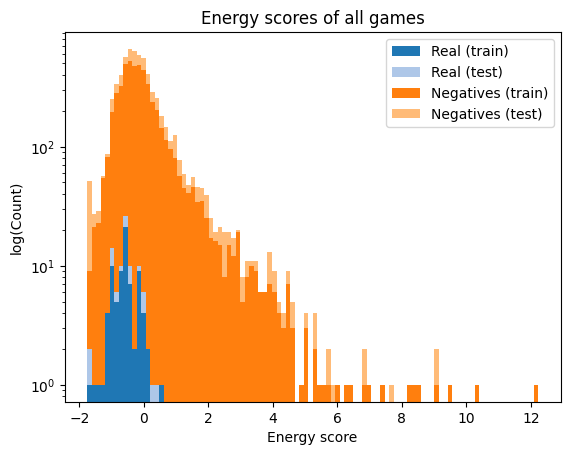

0.0023470493 0.02287838 4.6121598e-10


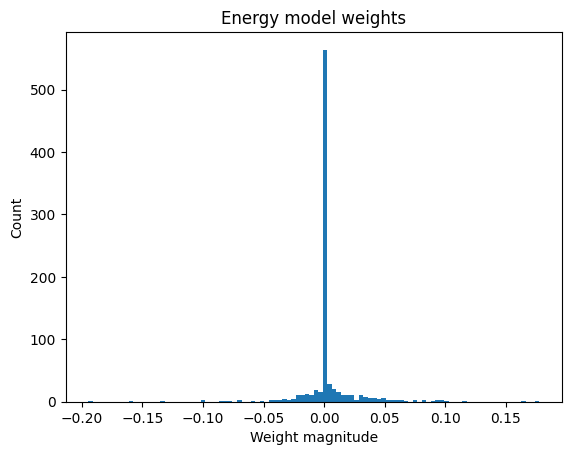

In [12]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

all_feature_columns = [c for c in filtered_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(fitness_df, test_param_grid,
    feature_columns=all_feature_columns, scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


print(test_results)

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)  #, histogram_title_note='with `real` flag')

In [13]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [ ]:
# cv.best_estimator_.fit(full_tensor)

SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
utils.evaluate_energy_contributions(cv, train_tensor, 3621, feature_columns, full_tensor, real_game_texts, regrown_game_texts, top_k=5)

### Trying with binarized features

In [12]:
BINARIZE_IGNORE_FEATURES = [
    'setup_objects_used', 'starts_and_ends_once', 'correct_predicate_function_arity',
    'section_without_pref_count_terminal', 'section_without_pref_count_scoring'
]  

BINARIZE_IGNORE_PATTERNS = [
    re.compile(r'max_depth_[\w\d_]+'), 
    re.compile(r'mean_depth_[\w\d_]+'), 
    re.compile(r'node_count_[\w\d_]+')
]  

BINARIZE_NON_ONE = [
    'all_variables_defined', 'all_variables_used', 
    'all_preferences_used', 'no_adjacent_once', 'variable_not_repeated',
    'no_nested_logicals', 'no_identical_logical_children',     
    'count_once_per_external_objects_used_correctly',         
    'external_forall_used_correctly', 'pref_forall_used',        
    'pref_forall_correct_arity', 'pref_forall_correct_types', 'no_two_number_operations'
]  

BINRARIZE_NONZERO_PATTERNS = [
    re.compile(r'arg_types_[\w_]+'), 
    re.compile(r'compositionality_structure_\d+')
]   

def binarize_features(df: pd.DataFrame, ignore_columns: typing.Iterable[str] = NON_FEATURE_COLUMNS) -> pd.DataFrame:
    binarized_df = df.copy(deep=True)

    for c in binarized_df.columns:
        if c in ignore_columns:
            continue

        if c in BINARIZE_IGNORE_FEATURES:
            continue 
        
        if any([p.match(c) for p in BINARIZE_IGNORE_PATTERNS]):
            continue

        if c in BINARIZE_NON_ONE:
            binarized_df[c] = (binarized_df[c] == 1).astype(int)

        if any([p.match(c) for p in BINRARIZE_NONZERO_PATTERNS]):
            binarized_df[c] = (binarized_df[c] != 0).astype(int)

    return binarized_df


binarized_df = binarize_features(fitness_df)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


### Test results:

{'ecdf': -0.28734615384615386, 'game_rank': 0.871874988079071}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
65,2,8,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,0.25,-0.237349,0.026366,1,0.870990,0.017125,108
608,4,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.01,1,835,0.00,-0.240148,0.033111,2,0.853776,0.025162,768
81,2,8,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,1,835,0.25,-0.240656,0.030034,3,0.869479,0.019070,207
1,2,4,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,0.25,-0.241227,0.033863,4,0.864180,0.019283,470
193,2,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,0.25,-0.241501,0.026361,5,0.874206,0.018008,10
548,4,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.01,2,835,0.00,-0.241545,0.027674,6,0.850234,0.020051,828
257,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,0.25,-0.241710,0.026033,7,0.874036,0.018551,12
321,4,4,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,0.25,-0.242907,0.019032,8,0.862721,0.017522,524
612,4,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.01,2,835,0.00,-0.243103,0.030755,9,0.860664,0.019268,584
273,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,1,835,0.25,-0.243139,0.028068,10,0.873828,0.019178,13


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
204,2,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.00,-0.252116,0.030734,151,0.877422,0.018145,1
268,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.00,-0.269068,0.037902,917,0.876849,0.019272,2
264,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,0.00,-0.272458,0.036064,983,0.876029,0.018990,3
514,4,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,1.00,-0.260453,0.025094,377,0.875964,0.019055,4
200,2,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,4,835,0.00,-0.263421,0.030924,667,0.875651,0.017386,5
132,2,16,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,2,835,0.00,-0.266029,0.034139,813,0.875195,0.017774,6
196,2,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,2,835,0.00,-0.267867,0.031819,884,0.875000,0.017641,7
12,2,4,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,8,835,0.00,-0.249608,0.030276,108,0.875000,0.019188,7
284,2,64,<function fitness_hinge_loss at 0x15e65e9e0>,0.03,8,835,0.00,-0.256665,0.035538,245,0.874557,0.017044,9
193,2,32,<function fitness_hinge_loss at 0x15e65e9e0>,0.10,1,835,0.25,-0.241501,0.026361,5,0.874206,0.018008,10


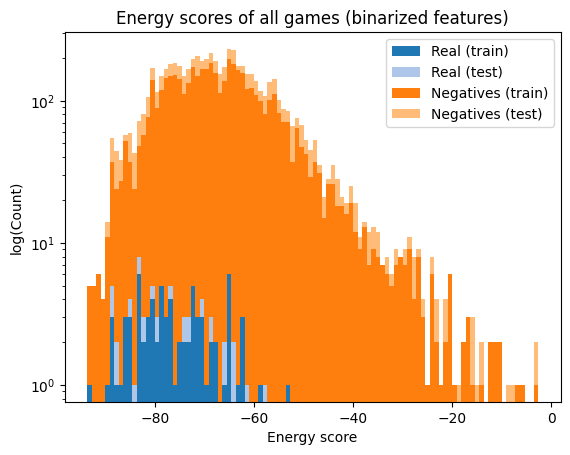

-0.023664756 0.9054758 0.01


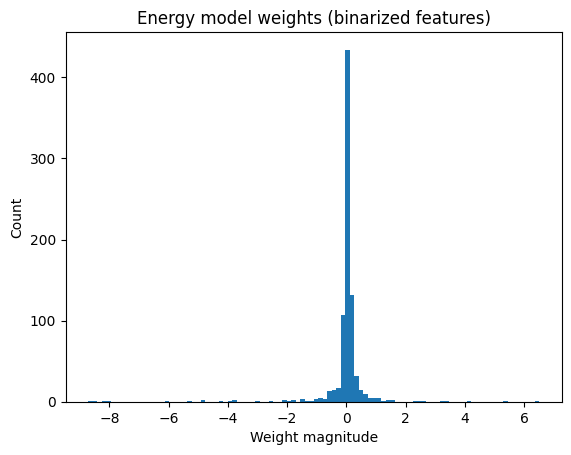

In [15]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_no_scaling, (train_tensor_no_scaling, test_tensor_no_scaling), test_results_no_scaling = utils.model_fitting_experiment(binarized_df, test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_no_scaling, train_tensor_no_scaling, test_tensor_no_scaling, test_results_no_scaling, histogram_title_note='binarized features')

In [16]:
SAVE_MODEL = False
if SAVE_MODEL:
    output_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv_no_scaling.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

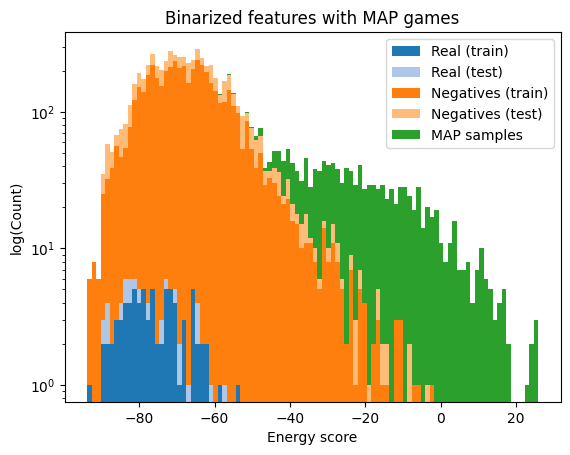

In [18]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games'

train_positive_scores = cv_no_scaling.best_estimator_.transform(train_tensor_no_scaling[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling.best_estimator_.transform(test_tensor_no_scaling[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling.best_estimator_.transform(train_tensor_no_scaling[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling.best_estimator_.transform(test_tensor_no_scaling[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

## Alternative experiments

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


### Test results:

{'ecdf': -0.20534615384615384, 'game_rank': 0.859375}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
236,2,32,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.208974,0.018823,1,0.840443,0.021862,5
232,2,32,<function fitness_square_square_loss at 0x1609...,0.010,4,835,0.0,-0.209465,0.019461,2,0.839453,0.022241,8
616,4,64,<function fitness_square_square_loss at 0x1609...,0.010,4,835,0.0,-0.210160,0.015626,3,0.835117,0.025012,17
316,2,64,<function fitness_square_square_loss at 0x1609...,0.003,8,835,0.0,-0.210596,0.019088,4,0.848281,0.023389,3
612,4,64,<function fitness_square_square_loss at 0x1609...,0.010,2,835,0.0,-0.211543,0.016479,5,0.820130,0.025962,109
228,2,32,<function fitness_square_square_loss at 0x1609...,0.010,2,835,0.0,-0.211570,0.013220,6,0.835404,0.024149,16
172,2,16,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.211732,0.019154,7,0.838424,0.024435,11
312,2,64,<function fitness_square_square_loss at 0x1609...,0.003,4,835,0.0,-0.211978,0.014615,8,0.838893,0.020758,10
296,2,64,<function fitness_square_square_loss at 0x1609...,0.010,4,835,0.0,-0.212494,0.018243,9,0.852357,0.022934,2
940,8,64,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.212701,0.018988,10,0.839284,0.026027,9


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
300,2,64,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.216874,0.018519,22,0.855143,0.022638,1
296,2,64,<function fitness_square_square_loss at 0x1609...,0.010,4,835,0.0,-0.212494,0.018243,9,0.852357,0.022934,2
316,2,64,<function fitness_square_square_loss at 0x1609...,0.003,8,835,0.0,-0.210596,0.019088,4,0.848281,0.023389,3
620,4,64,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.212945,0.017544,11,0.844766,0.023916,4
236,2,32,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.208974,0.018823,1,0.840443,0.021862,5
292,2,64,<function fitness_square_square_loss at 0x1609...,0.010,2,835,0.0,-0.213499,0.017293,12,0.840052,0.022228,6
108,2,8,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.216587,0.019512,20,0.839818,0.020338,7
232,2,32,<function fitness_square_square_loss at 0x1609...,0.010,4,835,0.0,-0.209465,0.019461,2,0.839453,0.022241,8
940,8,64,<function fitness_square_square_loss at 0x1609...,0.010,8,835,0.0,-0.212701,0.018988,10,0.839284,0.026027,9
312,2,64,<function fitness_square_square_loss at 0x1609...,0.003,4,835,0.0,-0.211978,0.014615,8,0.838893,0.020758,10


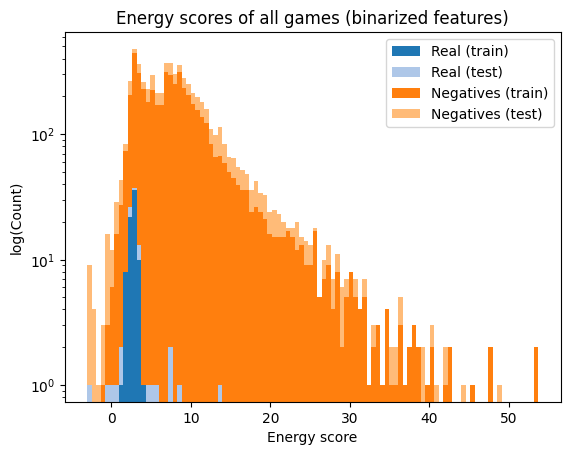

0.22361867 0.89092815 6.488721


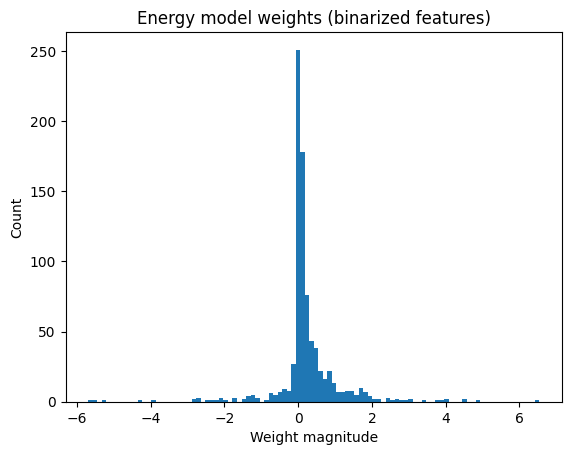

In [13]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
    # {
    # #     'fitness__loss_function': [utils.fitness_log_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # # },
    # # {
    # #     'fitness__loss_function': [utils.fitness_square_square_loss],
    # #     'fitness__weight_decay': [0.0, 0.125, 0.25, 0.5, 1],  
    # #     'fitness__margin': [1, 2, 4],
    # #     'fitness__lr': [1e-2, 3e-3, 1e-3, 3e-4],
    # #     'fitness__k': [16, 32, 64, 128],
    # #     'fitness__batch_size': [1, 4, 8, 16],
    # },   
]

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='single_game_rank')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_no_scaling_sq_sq, (train_tensor_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq), test_results_no_scaling_sq_sq = utils.model_fitting_experiment(binarized_df, test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs,
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


utils.visualize_cv_outputs(cv_no_scaling_sq_sq, train_tensor_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, test_results_no_scaling_sq_sq, histogram_title_note='binarized features')

In [14]:
SAVE_MODEL = True
if SAVE_MODEL:
    output_path = '../models/cv_binarized_sq_sq_model_2023_01_20.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv_no_scaling_sq_sq.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling_sq_sq.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

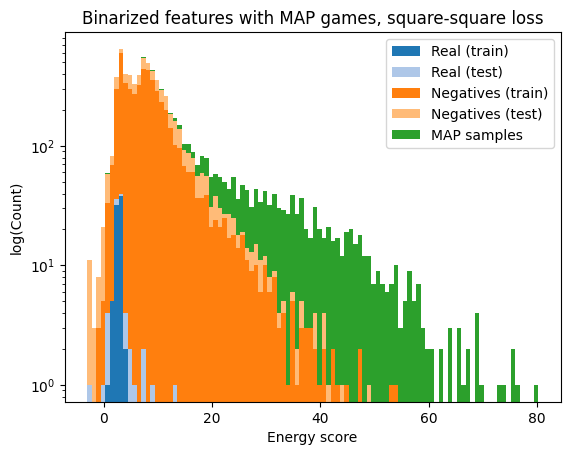

In [17]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games, square-square loss'

train_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

In [53]:
full_binarized_tensor = utils.df_to_tensor(binarized_df, [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS])
test_negative_scores_tensor = torch.tensor(test_negative_scores)
test_positive_scores_tensor = torch.tensor(test_positive_scores)
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]

In [56]:
torch.topk((test_negative_scores_tensor - test_positive_scores_tensor.unsqueeze(-1)).ravel(), 30, largest=False)

torch.return_types.topk(
values=tensor([-4.2568, -4.2568, -4.2568, -3.2389, -2.1113, -2.1033, -1.9959, -1.9562,
        -1.9521, -1.8398, -1.7114, -1.6755, -1.5235, -1.4765, -1.4765, -1.3746,
        -1.3104, -0.9833, -0.9544, -0.9025, -0.8647, -0.8647, -0.8647, -0.8647,
        -0.8623, -0.8623, -0.8346, -0.7194, -0.5622, -0.5432]),
indices=tensor([ 903,  944,  926,  682, 1036,  518, 1087,  657,  976,  693, 1063, 1098,
         641,  686,  659,  696, 1205, 1074, 1187, 1056,  532,  298,  195,  918,
         270,  269, 1167, 1162, 1153, 1214]))

In [29]:
test_negative_scores_tensor.ravel()[836] == test_negative_scores_tensor[836 // 64, 836 % 64]

tensor(True)

In [72]:
utils.evaluate_energy_contributions(
    cv_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, 1036,
    feature_columns, full_binarized_tensor, real_game_texts, regrown_game_texts,
)

Energy of real game: 7.167 | Energy of index: 5.056 | Difference: -2.111


### Top features pushing the energy down relative to real game [(feature value => scaled feature value) X (weight)]

arg_types_adjacent_room_features_agent: -1.711 = (0.000 => 0.000 | 1.000 => 1.000) * 1.711

compositionality_structure_4: -0.285 = (0.000 => 0.000 | 1.000 => 1.000) * 0.285

arg_types_on_receptacles_balls: -0.115 = (1.000 => 1.000 | 0.000 => 0.000) * -0.115

### Game Diffs

Original game index: 86 | Negative game row: 16 | Negative game col: 12


n,1,(define (game 6106ac34408681f3b0d07396-104) (:domain few-objects-room-v1),n,1,(define (game 6106ac34408681f3b0d07396-104-12) (:domain few-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(equal_x_position ?h east_sliding_door),,7,(equal_x_position ?h east_sliding_door)
,8,),,8,)
,9,),,9,)
,10,),,10,)
,11,),,11,)


### Feature Diffs

arg_types_adjacent_room_features_agent: -1.000 (1.000 => 0.000)
compositionality_structure_4: -1.000 (1.000 => 0.000)
arg_types_on_receptacles_balls: 1.000 (0.000 => 1.000)


* **TODO**: why is `(not 10)` a valid expression??

In [65]:
ast = grammar_parser.parse(regrown_game_texts[65 * 64 + 42])

In [67]:
from src import fitness_features
featurizer = fitness_features.build_fitness_featurizer(None)